**What is the differences between RNN & LSTM?**

Before I tell you what is LSTM let me tell you about the biggest problem with RNNs. So far everything looks good about RNNs until we train it via back-propagation. As the gradient of our training samples gets propagated backward through our network, it gets weaker and weaker, by the time it gets to those neurons that represent older data points in our time-series it has no juice to adjust them properly. This problem is called Vanishing Gradient. A LSTM cell is a type of RNN which stores important information about the past and forgets the unimportant pieces. In this way, when gradient back-propagates, it won’t be consumed by unnecessary information.

<a href="https://ibb.co/"><img src="https://i.ibb.co/3yN3G91/rnn-vs-lstm.jpg" alt="resim_a" border="2"></a>

*We will use our 50 datas to predict 51th data. Also I will take first 200000 datas*

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#import warnings
#warnings.filterwarnings("ignore")


#import os
#print(os.listdir("../input"))


In [2]:
bit_data=pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

What I did here? I added a colum which is "date" and I converted "Timestamp" columns to date form.

In [3]:
data.shape

(2627,)

In [4]:
bit_data.shape
bit_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-12-31


In [5]:
data.isnull().sum()

0

In [6]:
data.head()

date
2011-12-31    4.482500
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.223333
Name: Close, dtype: float64

The goal is making a prediction of daily close datas. So we will predict "close" values of bitcoin datas

**First I will use RNN to predict our datas**

In [7]:
close_train=data.iloc[:len(data)-100]
close_test=data.iloc[len(close_train):]
print(close_train.shape)

(2527,)


Here I will set our values between 0-1 in order to avoid domination of bigger values.

In [8]:
#feature scalling (set values between 0-1)
close_train=np.array(close_train)
print(close_train.shape)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

(2527,)


Let's choose every 50 datas as x-train and 51th as y-train

In [9]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (2477, 50, 1)
y_train shape=  (2477,)


In [ ]:
x_train

Time to prepare and run our RNN method

In [1]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
#from keras.optimizers import Adam, LeakyReLU
from keras.layers.advanced_activations import LeakyReLU

In [50]:
D_model = Sequential([
    Dense(128,input_shape=(1,50,1)),
    LeakyReLU(),
    BatchNormalization(axis=1),
    Dense(256),
    LeakyReLU(),
    BatchNormalization(axis=1),
    Dense(512),
    LeakyReLU(),
    BatchNormalization(),
    Dense(256),
    LeakyReLU(),
    BatchNormalization(axis=1),
    Dropout(0.2),
    Dense(1),
    LeakyReLU()
])

D_model.compile(Adam(), loss="mean_squared_error", metrics=['accuracy'])

In [51]:
x_train.shape

(2477, 50, 1)

In [52]:
D_history = D_model.fit(x_train,y_train,epochs=100,batch_size=64)

ValueError: Error when checking input: expected dense_81_input to have 4 dimensions, but got array with shape (2477, 50, 1)

In [12]:
es = EarlyStopping(monitor='val_loss',min_delta = 0.0005,patience =5,restore_best_weights=False)
#cp = ModelCheckpoint(filepath ='best_model.h5', monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='max')
#rLRoP = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callback = [es]#,cp,rLRoP];

In [13]:
regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(20,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(1))
#second RNN layer
#regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
#regressor.add(Dropout(0.25))
#third RNN layer
#regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
#regressor.add(Dropout(0.35))
#fourth RNN layer
#regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
#regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(20,activation="relu",return_sequences=True))
regressor.add(Dropout(1))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))


Instructions for updating:
Colocations handled automatically by placer.


In [14]:
regressor.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])
R_history = regressor.fit(x_train,y_train,epochs=100,batch_size=64, callbacks = callback)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2477/2477 [==============================] - 5s 2ms/step - loss: 0.0031 - acc: 8.0743e-04
Epoch 2/100
 448/2477 [====>.........................] - ETA: 0s - loss: 7.5567e-04 - acc: 0.0000e+00

C:\Users\vss\Anaconda3\lib\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


2477/2477 [==============================] - 1s 396us/step - loss: 9.7514e-04 - acc: 8.0743e-04
Epoch 3/100
2477/2477 [==============================] - 1s 387us/step - loss: 7.8550e-04 - acc: 8.0743e-04
Epoch 4/100
2477/2477 [==============================] - 1s 366us/step - loss: 6.9541e-04 - acc: 8.0743e-04
Epoch 5/100
2477/2477 [==============================] - 1s 370us/step - loss: 6.1959e-04 - acc: 8.0743e-04
Epoch 6/100
2477/2477 [==============================] - 1s 426us/step - loss: 5.4319e-04 - acc: 8.0743e-04
Epoch 7/100
2477/2477 [==============================] - 1s 380us/step - loss: 5.3132e-04 - acc: 8.0743e-04
Epoch 8/100
2477/2477 [==============================] - 1s 371us/step - loss: 4.1827e-04 - acc: 8.0743e-04
Epoch 9/100
2477/2477 [==============================] - 1s 369us/step - loss: 3.7672e-04 - acc: 8.0743e-04
Epoch 10/100
2477/2477 [==============================] - 1s 430us/step - loss: 3.7744e-04 - acc: 8.0743e-04
Epoch 11/100
2477/2477 [===============

2477/2477 [==============================] - 1s 364us/step - loss: 1.1220e-04 - acc: 8.0743e-04
Epoch 78/100
2477/2477 [==============================] - 1s 363us/step - loss: 1.1403e-04 - acc: 8.0743e-04
Epoch 79/100
2477/2477 [==============================] - 1s 357us/step - loss: 1.2474e-04 - acc: 8.0743e-04
Epoch 80/100
2477/2477 [==============================] - 1s 358us/step - loss: 9.1347e-05 - acc: 8.0743e-04
Epoch 81/100
2477/2477 [==============================] - 1s 366us/step - loss: 8.6809e-05 - acc: 8.0743e-04
Epoch 82/100
2477/2477 [==============================] - 1s 361us/step - loss: 8.9977e-05 - acc: 8.0743e-04
Epoch 83/100
2477/2477 [==============================] - 1s 362us/step - loss: 9.8163e-05 - acc: 8.0743e-04
Epoch 84/100
2477/2477 [==============================] - 1s 363us/step - loss: 1.0328e-04 - acc: 8.0743e-04
Epoch 85/100
2477/2477 [==============================] - 1s 362us/step - loss: 9.0657e-05 - acc: 8.0743e-04
Epoch 86/100
2477/2477 [========

In [15]:
print(R_history.history.keys())

dict_keys(['loss', 'acc'])


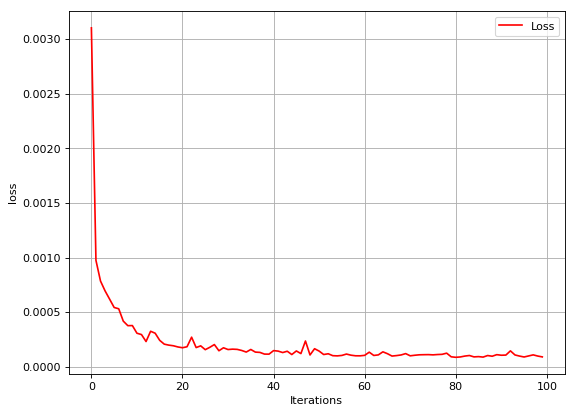

In [20]:
plt.figure(figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(R_history.history["loss"],color="r",label="Loss")
#plt.plot(R_history.history["acc"],color="b",label="Accur")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.grid(True)
plt.show()

Now we are preparing our test data for prediction

In [21]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [22]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)
x_test.shape

(100, 50, 1)

In [23]:
predicted_data_RNN=regressor.predict(x_test)
predicted_data_RNN=scaler.inverse_transform(predicted_data_RNN)

**What did we do???? We learnt our model with train datas and then we tried to predict next 50 datas (train data=50). Then we compared predictions with our test (real) datas.**

In [24]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

In [29]:
#plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
#plt.plot(data_test,color="r",label="true result")
#plt.plot(predicted_data_RNN,color="b",label="predicted result_RNN")
#plt.legend()
#plt.xlabel("Time(50 days)")
#plt.ylabel("Close Values")
#plt.grid(True)
#plt.show()

Here we have the results of our prediction. As we can see on the chart that with RNN method we don't have a good result. So let's check LSTM method, then we can compare both results.

**Keep going with LSTM method**

I will use the same train and test datas

In [25]:
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten


In [26]:
x_train.shape

(2477, 50, 1)

In [29]:
model=Sequential()

model.add(LSTM(30,activation="relu",input_shape=(None,1)))

model.add(Dense(1))

In [30]:
model.compile(loss="mean_squared_error",optimizer="adam",metrics=['accuracy'])#,callbacks = callback)
#activation='tanh', recurrent_activation='hard_sigmoid'
history1 = model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2477/2477 [==============================] - 5s 2ms/step - loss: 0.0123 - acc: 8.0743e-04
Epoch 2/100
2477/2477 [==============================] - 3s 1ms/step - loss: 7.8297e-04 - acc: 8.0743e-04
Epoch 3/100
2477/2477 [==============================] - 3s 1ms/step - loss: 6.0359e-04 - acc: 8.0743e-04
Epoch 4/100
2477/2477 [==============================] - 4s 1ms/step - loss: 4.5562e-04 - acc: 8.0743e-04
Epoch 5/100
2477/2477 [==============================] - 3s 1ms/step - loss: 4.1067e-04 - acc: 8.0743e-04
Epoch 6/100
2477/2477 [==============================] - 4s 1ms/step - loss: 3.8698e-04 - acc: 8.0743e-04
Epoch 7/100
2477/2477 [==============================] - 4s 1ms/step - loss: 3.6582e-04 - acc: 8.0743e-04
Epoch 8/100
2477/2477 [==============================] - 3s 1ms/step - loss: 3.5959e-04 - acc: 8.0743e-04
Epoch 9/100
2477/2477 [==============================] - 3s 1ms/step - loss: 3.2228e-04 - acc: 8.0743e-04
Epoch 10/100
2477/2477 [==========================

Adding multiple LSTM layers to model 

In [24]:
model2=Sequential()

model2.add(LSTM(10,activation="relu",return_sequences=True,input_shape=(None,1)))

#model2.add(LSTM(20,return_sequences=True,activation="relu"))

model2.add(LSTM(10,activation="relu"))

model2.add(Dense(1))

In [25]:
model2.compile(loss="mean_squared_error",optimizer="adam",metrics=['accuracy'])#,callbacks = callback)
#activation='tanh', recurrent_activation='hard_sigmoid'
history2 = model2.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2477/2477 [==============================] - 10s 4ms/step - loss: 0.0160 - acc: 4.0371e-04
Epoch 2/100
2477/2477 [==============================] - 6s 2ms/step - loss: 0.0014 - acc: 8.0743e-04
Epoch 3/100
2477/2477 [==============================] - 6s 2ms/step - loss: 0.0010 - acc: 8.0743e-04
Epoch 4/100
2477/2477 [==============================] - 6s 2ms/step - loss: 7.4460e-04 - acc: 8.0743e-04
Epoch 5/100
2477/2477 [==============================] - 5s 2ms/step - loss: 6.3020e-04 - acc: 8.0743e-04
Epoch 6/100
2477/2477 [==============================] - 8s 3ms/step - loss: 5.8671e-04 - acc: 8.0743e-04
Epoch 7/100
2477/2477 [==============================] - 7s 3ms/step - loss: 5.7264e-04 - acc: 8.0743e-04
Epoch 8/100
2477/2477 [==============================] - 7s 3ms/step - loss: 5.4791e-04 - acc: 8.0743e-04
Epoch 9/100
2477/2477 [==============================] - 7s 3ms/step - loss: 5.0889e-04 - acc: 8.0743e-04
Epoch 10/100
2477/2477 [==============================] -

Keep going with test data

In [26]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [27]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

it's time to predict

In [28]:
predicted_data_LSTM1=model.predict(x_test)
predicted_data_LSTM1=scaler.inverse_transform(predicted_data_LSTM1)

In [29]:
predicted_data_LSTM2=model2.predict(x_test)
predicted_data_LSTM2=scaler.inverse_transform(predicted_data_LSTM2)

In [30]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

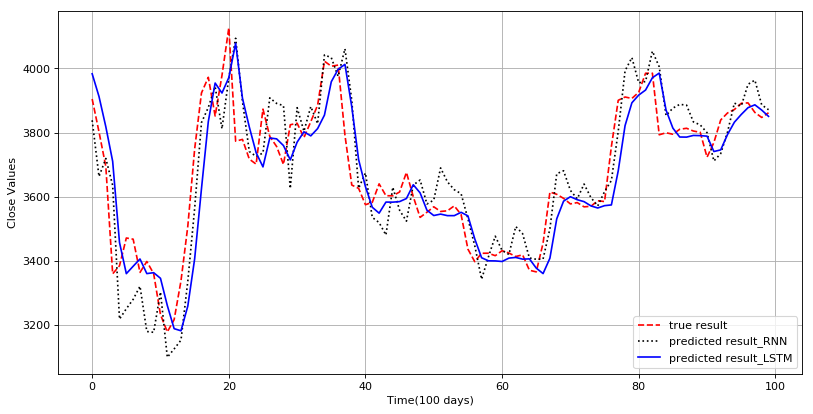

In [56]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result",linestyle = '--')
plt.plot(predicted_data_RNN,color="k",label="predicted result_RNN",linestyle = ':')
plt.plot(predicted_data_LSTM1,color="b",label="predicted result_LSTM")
#plt.plot(predicted_data_LSTM2,color="r",label="predicted result_LSTM2")
plt.legend()
plt.xlabel("Time(100 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()

In [42]:
print(history1.history.keys())

dict_keys(['loss', 'acc'])


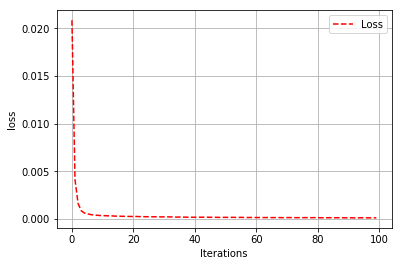

In [39]:
plt.plot(history1.history["loss"],color="r",label="Loss",linestyle = '--')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.grid(True)
plt.show()


* ** Conclusion**

When we compare the both results (RNN and LSTM) we can see that we have better prediction with LSTM. 

Up to here I was trying to show the differences between RNN and LSTM. If you have any question or I have any error please write me dirctly.


In [37]:
import matplotlib


In [38]:
help matplotlib


SyntaxError: invalid syntax (<ipython-input-38-5b7c6061e86f>, line 1)

In [5]:
python

NameError: name 'python' is not defined

In [6]:
python --version

NameError: name 'python' is not defined

In [8]:
import platform
platform.python_version()

'3.7.1'